In [45]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet121, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Function to Create Model


In [8]:
def create_model(base_model, input_shape=(224, 224, 3), num_classes=2):
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Data Generators


In [18]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

"""train_generator_bin = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator_bin = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator_bin = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)"""

train_generator_cat = train_datagen.flow_from_directory(
    r'E:\Programing\ML\Rail-damage-detection\dataset\dataset_split\train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator_cat = val_datagen.flow_from_directory(
    r'E:\Programing\ML\Rail-damage-detection\dataset\dataset_split\val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator_cat = test_datagen.flow_from_directory(
   r'E:\Programing\ML\Rail-damage-detection\dataset\dataset_split\test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)



Found 10771 images belonging to 2 classes.
Found 1345 images belonging to 2 classes.
Found 1348 images belonging to 2 classes.


## ResNet50


In [19]:
# Load the ResNet50 model with pretrained weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = create_model(resnet_base)

# Train the model
resnet_history = resnet_model.fit(train_generator_cat, epochs=10, validation_data=val_generator_cat)

# Evaluate the model on the validation and test data
resnet_val_loss, resnet_val_acc = resnet_model.evaluate(val_generator_cat)
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_generator_cat)

# Print the results
print(f"ResNet - Validation Loss: {resnet_val_loss}, Validation Accuracy: {resnet_val_acc}")
print(f"ResNet - Test Loss: {resnet_test_loss}, Test Accuracy: {resnet_test_acc}")


Epoch 1/10


e:\Programing\ML\ml-venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


337/337 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.8148 - loss: 0.6439 - val_accuracy: 0.9152 - val_loss: 0.2070
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.9154 - loss: 0.2124 - val_accuracy: 0.9108 - val_loss: 0.2091
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 793s 2s/step - accuracy: 0.9326 - loss: 0.1793 - val_accuracy: 0.9056 - val_loss: 0.2418
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 791s 2s/step - accuracy: 0.9436 - loss: 0.1498 - val_accuracy: 0.8743 - val_loss: 0.4516
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - accuracy: 0.9164 - loss: 0.2134 - val_accuracy: 0.9316 - val_loss: 0.1785
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - accuracy: 0.9487 - loss: 0.1339 - val_accuracy: 0.9524 - val_loss: 0.1270
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.9518 - loss: 0.1263 - val_accuracy: 0.9680 - val_loss: 0.0854
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.9620 - loss: 0.1057 - val_accuracy: 0.968

### Saving the Model


In [44]:
resnet_model.save(r'E:\Programing\ML\Rail-damage-detection\models\v2\resnet_model.h5')

In [22]:
# Make predictions on the test set
test_steps_per_epoch = np.math.ceil(test_generator_cat.samples / test_generator_cat.batch_size)
predictions = resnet_model.predict(test_generator_cat, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator_cat.classes
class_labels = list(test_generator_cat.class_indices.keys())

43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step


### Confusion Matrix


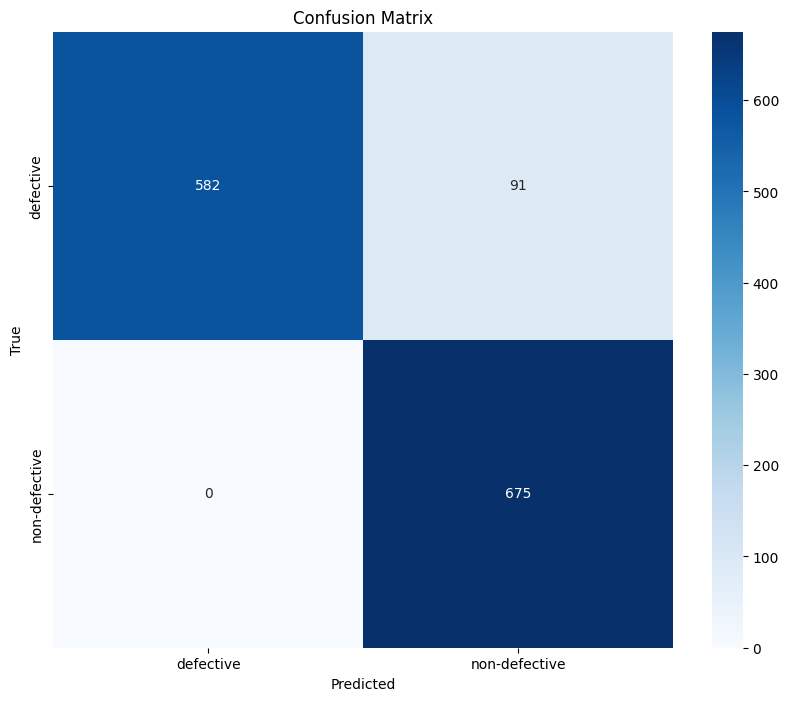

In [23]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)

Classification Report
               precision    recall  f1-score   support

    defective       1.00      0.86      0.93       673
non-defective       0.88      1.00      0.94       675

     accuracy                           0.93      1348
    macro avg       0.94      0.93      0.93      1348
 weighted avg       0.94      0.93      0.93      1348



## VGG16


In [26]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = create_model(vgg_base)
vgg_history = vgg_model.fit(train_generator_cat, epochs=10, validation_data=val_generator_cat)
vgg_val_loss, vgg_val_acc = vgg_model.evaluate(val_generator_cat)
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(test_generator_cat)
print(f"VGG - Validation Loss: {vgg_val_loss}, Validation Accuracy: {vgg_val_acc}")
print(f"VGG - Test Loss: {vgg_test_loss}, Test Accuracy: {vgg_test_acc}")

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.9338 - loss: 0.1563 - val_accuracy: 0.9836 - val_loss: 0.0371
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 770s 2s/step - accuracy: 0.9878 - loss: 0.0322 - val_accuracy: 0.9948 - val_loss: 0.0124
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 773s 2s/step - accuracy: 0.9938 - loss: 0.0162 - val_accuracy: 0.9918 - val_loss: 0.0183
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.9951 - loss: 0.0127 - val_accuracy: 0.9963 - val_loss: 0.0118
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.9953 - loss: 0.0139 - val_accuracy: 0.9933 - val_loss: 0.0237
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 767s 2s/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9911 - val_loss: 0.0231
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.9982 - loss: 0.0074 - val_accuracy: 0.9829 - val_loss: 0.0648
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - accuracy: 0.9917 - loss: 0.0205 - val_accu

### Saving the Model


In [37]:
vgg_model.save(r'E:\Programing\ML\Rail-damage-detection\models\v2\vgg_model.keras')

In [29]:
# Make predictions on the test set
test_steps_per_epoch = np.math.ceil(test_generator_cat.samples / test_generator_cat.batch_size)
vgg_predictions = vgg_model.predict(test_generator_cat, steps=test_steps_per_epoch)
vgg_predicted_classes = np.argmax(vgg_predictions, axis=1)
vgg_true_classes = test_generator_cat.classes
class_labels = list(test_generator_cat.class_indices.keys())

43/43 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step


### Confusion Matrix


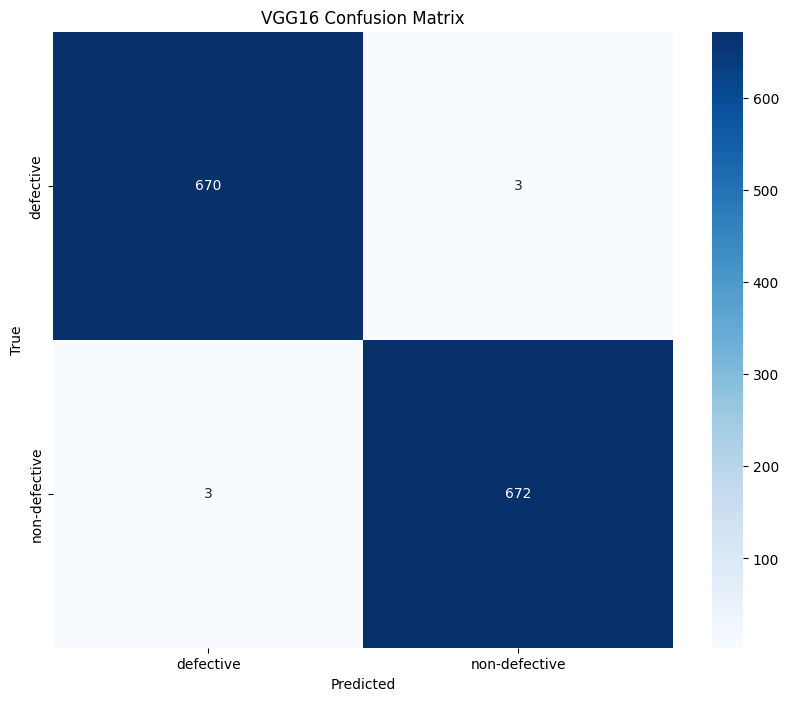

In [30]:
vgg_conf_matrix = confusion_matrix(vgg_true_classes, vgg_predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(vgg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('VGG16 Confusion Matrix')
plt.show()

In [31]:
vgg_report = classification_report(vgg_true_classes, vgg_predicted_classes, target_names=class_labels)
print('VGG16 Classification Report')
print(vgg_report)

VGG16 Classification Report
               precision    recall  f1-score   support

    defective       1.00      1.00      1.00       673
non-defective       1.00      1.00      1.00       675

     accuracy                           1.00      1348
    macro avg       1.00      1.00      1.00      1348
 weighted avg       1.00      1.00      1.00      1348



### DenseNet


In [33]:
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_model = create_model(densenet_base)
densenet_history = densenet_model.fit(train_generator_cat, epochs=10, validation_data=val_generator_cat)
densenet_val_loss, densenet_val_acc = densenet_model.evaluate(val_generator_cat)
densenet_test_loss, densenet_test_acc = densenet_model.evaluate(test_generator_cat)
print(f"DenseNet - Validation Loss: {densenet_val_loss}, Validation Accuracy: {densenet_val_acc}")
print(f"DenseNet - Test Loss: {densenet_test_loss}, Test Accuracy: {densenet_test_acc}")

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 796s 2s/step - accuracy: 0.9383 - loss: 0.3627 - val_accuracy: 0.9933 - val_loss: 0.0174
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.9896 - loss: 0.0271 - val_accuracy: 0.9941 - val_loss: 0.0161
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 778s 2s/step - accuracy: 0.9917 - loss: 0.0234 - val_accuracy: 0.9926 - val_loss: 0.0254
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.9916 - loss: 0.0281 - val_accuracy: 0.9918 - val_loss: 0.0246
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.9968 - loss: 0.0090 - val_accuracy: 0.9933 - val_loss: 0.0214
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 775s 2s/step - accuracy: 0.9965 - loss: 0.0108 - val_accuracy: 0.9941 - val_loss: 0.0183
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.9960 - loss: 0.0073 - val_accuracy: 0.9933 - val_loss: 0.0324
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.9929 - loss: 0.0249 - val_accu

### Saving the Model


In [41]:
densenet_model.save_weights(r'E:\Programing\ML\Rail-damage-detection\models\v2\densenet_model.weights.h5')

In [36]:
# Make predictions with DenseNet model
densenet_predictions = densenet_model.predict(test_generator_cat)
densenet_predicted_classes = np.argmax(densenet_predictions, axis=1)
densenet_true_classes = test_generator_cat.classes

43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step


### Confusion Matrix


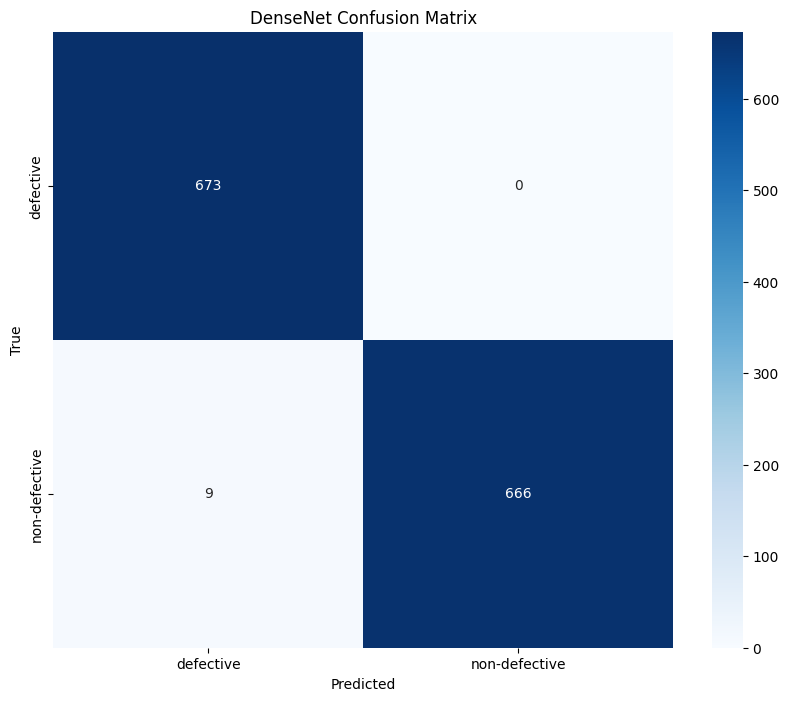

In [38]:
densenet_conf_matrix = confusion_matrix(densenet_true_classes, densenet_predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(densenet_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DenseNet Confusion Matrix')
plt.show()

In [39]:
# Classification report for DenseNet
densenet_report = classification_report(densenet_true_classes, densenet_predicted_classes, target_names=class_labels)
print('DenseNet Classification Report')
print(densenet_report)

DenseNet Classification Report
               precision    recall  f1-score   support

    defective       0.99      1.00      0.99       673
non-defective       1.00      0.99      0.99       675

     accuracy                           0.99      1348
    macro avg       0.99      0.99      0.99      1348
 weighted avg       0.99      0.99      0.99      1348



### MobileNet


In [48]:
# Create and train the MobileNetV2 model
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model = create_model(mobilenet_base)
mobilenet_history = mobilenet_model.fit(train_generator_cat, epochs=5, validation_data=val_generator_cat)
mobilenet_val_loss, mobilenet_val_acc = mobilenet_model.evaluate(val_generator_cat)
mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(test_generator_cat)
print(f"MobileNetV2 - Validation Loss: {mobilenet_val_loss}, Validation Accuracy: {mobilenet_val_acc}")
print(f"MobileNetV2 - Test Loss: {mobilenet_test_loss}, Test Accuracy: {mobilenet_test_acc}")

Epoch 1/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - accuracy: 0.9566 - loss: 0.2407 - val_accuracy: 0.9911 - val_loss: 0.0212
Epoch 2/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 495s 1s/step - accuracy: 0.9896 - loss: 0.0372 - val_accuracy: 0.9933 - val_loss: 0.0187
Epoch 3/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.9921 - loss: 0.0345 - val_accuracy: 0.9970 - val_loss: 0.0080
Epoch 4/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 489s 1s/step - accuracy: 0.9923 - loss: 0.0339 - val_accuracy: 0.9955 - val_loss: 0.0211
Epoch 5/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 489s 1s/step - accuracy: 0.9958 - loss: 0.0149 - val_accuracy: 0.9926 - val_loss: 0.0349
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 878ms/step - accuracy: 0.9895 - loss: 0.0567
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 931ms/step - accuracy: 0.9972 - loss: 0.0153
MobileNetV2 - Validation Loss: 0.03491658344864845, Validation Accuracy: 0.9925650358200073
MobileNetV2 - Test Loss: 0.02165365032851696, Test Accuracy: 0.9955489635467529


### Saving the Model


In [53]:
mobilenet_model.save(r'E:\Programing\ML\Rail-damage-detection\models\v2\mobilenet_model.keras')

### AlexNet


In [50]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

# Function to create AlexNet model
def create_alexnet(input_shape=(224, 224, 3), num_classes=2):
    model = tf.keras.Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the AlexNet model
alexnet_model = create_alexnet()
alexnet_history = alexnet_model.fit(train_generator_cat, epochs=10, validation_data=val_generator_cat)
alexnet_val_loss, alexnet_val_acc = alexnet_model.evaluate(val_generator_cat)
alexnet_test_loss, alexnet_test_acc = alexnet_model.evaluate(test_generator_cat)
print(f"AlexNet - Validation Loss: {alexnet_val_loss}, Validation Accuracy: {alexnet_val_acc}")
print(f"AlexNet - Test Loss: {alexnet_test_loss}, Test Accuracy: {alexnet_test_acc}")



e:\Programing\ML\ml-venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.8383 - loss: 0.3049 - val_accuracy: 0.9807 - val_loss: 0.1055
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.9775 - loss: 0.0678 - val_accuracy: 0.9836 - val_loss: 0.0424
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.9795 - loss: 0.0664 - val_accuracy: 0.9911 - val_loss: 0.0317
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.9857 - loss: 0.0444 - val_accuracy: 0.9799 - val_loss: 0.0525
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.9836 - loss: 0.0520 - val_accuracy: 0.9822 - val_loss: 0.0661
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.9850 - loss: 0.0417 - val_accuracy: 0.9918 - val_loss: 0.0264
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.9847 - loss: 0.0434 - val_accuracy: 0.9896 - val_loss: 0.0246
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.9835 - loss: 0.0452 - val_accu

In [52]:
alexnet_model.save(r'E:\Programing\ML\Rail-damage-detection\models\v2\alexnet_model.keras')